In [1]:
import pandas as pd
import datetime
import missingno
import os
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pytz

est = pytz.timezone('US/Eastern')
utc = pytz.utc

<b>Load Data and Join Initial Datasets, Clean as Needed</b>

In [2]:
#note for david's structure
cd = os.getcwd()
raw_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/raw/"
processed_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/processed/"

In [3]:
#enter your appriate path/paths here if the above doesn't work, up to the data folder you put the 
#raw and processed data folders in
                            #ENTER THE BEGINNING OF YOur PATH TO RAW AND PROCESSED HERE
raw_data_directory_path = 'C:/Users/heath/Desktop/W207/w207_final_project/w207_final_project/data/raw/'
processed_data_directory_path = 'C:/Users/heath/Desktop/W207/w207_final_project/w207_final_project/data/processed/'

<b>Get Tweet Datasets and Join </b>

In [4]:
tweets = pd.read_csv(raw_data_directory_path+'tweet_data/Tweet.csv')

In [5]:
company_tweets = pd.read_csv(raw_data_directory_path +'tweet_data/Company_Tweet.csv')

In [6]:
company = pd.read_csv(raw_data_directory_path +'tweet_data/Company.csv')

In [7]:
tweet_combo = pd.merge(tweets, company_tweets)

In [8]:
tweet_combo = pd.merge(tweet_combo, company)

In [9]:
tweet_combo.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG', 'GOOGL'], dtype=object)

<b>Get stock data for our tweet companies and join </b>

In [10]:
companynasdaq = pd.read_csv(raw_data_directory_path + 'stock_data/Company.csv')

In [11]:
company_val = pd.read_csv(raw_data_directory_path+'stock_data/CompanyValues.csv')

In [12]:
company_val.day_date = pd.to_datetime(company_val.day_date,format='%Y-%m-%d %H:%M:%S')

In [13]:
#we want to drop the duplicates and keep the max per day with hour min sec, and then convert back to just looking at the day.
#keeping the day makes it easier to join the datasets on tweets that day compared to market close and adjustment per day
company_val .sort_values(['day_date'], ascending=True, inplace=True)
company_val = company_val.drop_duplicates(subset = ['day_date', 'ticker_symbol'], keep = 'last')

In [14]:
#get stock data 2015 plus to match our tweet data dates
company_val.day_date = pd.to_datetime(company_val.day_date,format='%Y-%m-%d')
company_val = company_val.loc[company_val.day_date >= '2015-01-01']

In [15]:
#check to make sure filter worked
company_val.day_date.min()

Timestamp('2015-01-01 00:00:00')

In [16]:
stock_prices = pd.merge(company_val, companynasdaq)

In [17]:
stock_prices
stock_prices.sort_values(['day_date'], ascending=True, inplace=True)

In [18]:
stock_prices.ticker_symbol.unique() #keeping GOOG and GOOGL for now since both in twitter data

array(['MSFT', 'TSLA', 'GOOG', 'AMZN', 'GOOGL', 'AAPL'], dtype=object)

In [19]:
stock_prices.company_name.unique()

array(['Microsoft', 'Tesla Inc', 'Google Inc', 'Amazon.com', 'apple'],
      dtype=object)

In [55]:
#replacing 'GOOG' and 'GOOGL' are actually two different stocks from Google Inc.
#https://seekingalpha.com/article/4430928-which-google-stock-is-a-better-buy-goog-or-googl

In [20]:
#also we have duplicates every day now so just keep the latest one
stock_prices = stock_prices.drop_duplicates(subset = ['day_date', 'ticker_symbol'], keep = 'last')

In [21]:
tickers = list(stock_prices.ticker_symbol.unique())
tickers

['MSFT', 'TSLA', 'GOOG', 'AMZN', 'GOOGL', 'AAPL']

In [22]:
#create stock return % change from previous day
stock_prices['return'] = stock_prices.groupby('ticker_symbol')['close_value'].pct_change()

In [34]:
#need to convert the tweet post date to date time and also account for stock prices being in est, so make tweets est

In [24]:
tweet_combo.post_date = tweet_combo.post_date.apply(lambda x: datetime.datetime.fromtimestamp(x).astimezone(est).strftime('%Y-%m-%d'))
tweet_combo.post_date = pd.to_datetime(tweet_combo.post_date, format='%Y-%m-%d')

In [35]:
len(tweet_combo)

4336445

<b>Add S&P 500 Data</b>

In [36]:
sp500 = pd.read_csv(raw_data_directory_path+'stock_data/SP500_historical.csv')

In [37]:
sp500.Date = pd.to_datetime(sp500.Date)
sp500.sort_values(['Date'], ascending=True, inplace=True)

In [38]:
sp500.columns = ['day_date', 'sp_open', 'sp_high', 'sp_low', 'sp_close']

In [39]:
sp500['sp_pct_return'] = sp500['sp_close'].pct_change()

In [41]:
spcols = ['day_date', 'sp_close', 'sp_pct_return']
sp500 = sp500[spcols]

<b>Combine S&P 500 and Stock Data </b>

In [42]:
stock_prices = pd.merge(stock_prices, sp500)

In [56]:
stock_prices.head(50)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,company_name,return,sp_close,sp_pct_return
0,TSLA,2015-01-02,219.310,4753239,222.87,223.2500,213.2600,Tesla Inc,-0.013938,2058.20,NaN
1,GOOG,2015-01-02,524.810,1444809,529.01,531.2700,524.1000,Google Inc,-0.003021,2058.20,NaN
2,AAPL,2015-01-02,109.330,53143770,111.39,111.4400,107.3500,apple,-0.009513,2058.20,NaN
3,MSFT,2015-01-02,46.760,27843560,46.66,47.4200,46.5400,Microsoft,0.006674,2058.20,NaN
4,AMZN,2015-01-02,308.520,2785167,312.58,314.7500,306.9601,Amazon.com,-0.005897,2058.20,NaN
5,GOOGL,2015-01-02,529.550,1325271,532.60,535.8000,527.8800,Google Inc,-0.002092,2058.20,NaN
6,GOOGL,2015-01-05,519.460,2054120,527.15,527.9899,517.7500,Google Inc,-0.019054,2020.58,-0.018278
7,GOOG,2015-01-05,513.870,2049303,523.26,524.3300,513.0600,Google Inc,-0.020846,2020.58,-0.018278
8,AAPL,2015-01-05,106.250,64210880,108.29,108.6500,105.4100,apple,-0.028172,2020.58,-0.018278
9,TSLA,2015-01-05,210.090,5355485,214.55,216.5000,207.1626,Tesla Inc,-0.042041,2020.58,-0.018278


<b>Join Final Datasets - Stock Data with S&P 500 and Tweet Data </b>

In [45]:
#join on date and ticker symbol to get the stock price for the company for the date of the post
final_df = pd.merge(tweet_combo, stock_prices, left_on = ['post_date', 'ticker_symbol'], right_on = ['day_date', 'ticker_symbol'])

In [47]:
final_df

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,company_name_x,day_date,close_value,volume,open_value,high_value,low_value,company_name_y,return,sp_close,sp_pct_return
0,550886375860736000,TCBFx,2015-01-02,The Closing Bell is out! http://paper.li/BonaC...,0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,apple,-0.009513,2058.20,NaN
1,550887748803256320,FractalHIS,2015-01-02,$AAPL #AAPL Looking forward to seeing how this...,0,1,1,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,apple,-0.009513,2058.20,NaN
2,550888743654400000,pricatti,2015-01-02,#Balances #resultados #cartera #portfolio$aapl...,0,0,1,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,apple,-0.009513,2058.20,NaN
3,550889239680790528,stock_forums,2015-01-02,"$PNOW Percent Change Updated Thursday, January...",0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,apple,-0.009513,2058.20,NaN
4,550889252104327168,Chasing__Stars,2015-01-02,"$PLGC Stock Message Board Updated Thursday, Ja...",0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,apple,-0.009513,2058.20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705416,1212142968037138432,faang_gang,2019-12-31,$GOOGL also flat today,1,0,0,GOOGL,Google Inc,2019-12-31,1339.39,976061,1335.79,1340.66,1332.13,Google Inc,-0.000239,3230.78,0.002946
3705417,1212149780471853057,harveyrosenblum,2019-12-31,If this continues then the market will be enti...,0,0,2,GOOGL,Google Inc,2019-12-31,1339.39,976061,1335.79,1340.66,1332.13,Google Inc,-0.000239,3230.78,0.002946
3705418,1212150279656890374,luke_sosnowski,2019-12-31,Great day and years end over at #TRICKTRADES m...,1,2,7,GOOGL,Google Inc,2019-12-31,1339.39,976061,1335.79,1340.66,1332.13,Google Inc,-0.000239,3230.78,0.002946
3705419,1212150864066023427,Flower_Power_67,2019-12-31,#FastMoneyEspressoFINAL TRADES:Steve Grasso —>...,0,1,4,GOOGL,Google Inc,2019-12-31,1339.39,976061,1335.79,1340.66,1332.13,Google Inc,-0.000239,3230.78,0.002946


In [49]:
#lost x amount of tweets when merging stock data (171) - keeping days where stocks are traded - sp500 only contains trade days

In [46]:
len(tweet_combo) - len(final_df)

631024

In [48]:
final_df = final_df.rename(columns = {'company_name_x': 'company_name'})
final_df = final_df.drop(['company_name_y'], axis=1)

In [67]:
final_df.head(895)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,company_name,day_date,close_value,volume,open_value,high_value,low_value,return,sp_close,sp_pct_return
0,550886375860736000,TCBFx,2015-01-02,The Closing Bell is out! http://paper.li/BonaC...,0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
1,550887748803256320,FractalHIS,2015-01-02,$AAPL #AAPL Looking forward to seeing how this...,0,1,1,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
2,550888743654400000,pricatti,2015-01-02,#Balances #resultados #cartera #portfolio$aapl...,0,0,1,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
3,550889239680790528,stock_forums,2015-01-02,"$PNOW Percent Change Updated Thursday, January...",0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
4,550889252104327168,Chasing__Stars,2015-01-02,"$PLGC Stock Message Board Updated Thursday, Ja...",0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,551238715277062144,intltrade2,2015-01-02,testing this buy $AAPL,0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
891,551238755189661696,kevinbantz,2015-01-02,Commented on StockTwits: sunset better but $AA...,0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
892,551238883946811393,Sara20992,2015-01-02,Free 5€ in account balance for first 100.000 m...,0,0,0,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN
893,551239679165476864,SwingTradeAlert,2015-01-02,"IBD:Apple, Other IBD 50 Stock Leaders Close Be...",0,2,1,AAPL,apple,2015-01-02,109.33,53143770,111.39,111.44,107.35,-0.009513,2058.20,NaN


<b>Export to appropriate path here</b>

In [51]:
#note that cleaned data features include:
    #joining tweet datasets on tweet IDs and then to stock data on post date (tweet data) and day date (stock data) and ticker symbol
    #making return per stock (percent change from previous day) - make over week for final dataset
    #converting datetimes and considerations for est
    #keeping stock data greater than 2015 to match our tweet data
    #acsending date sorting
    #added S&P 500 data - close value and percent change from previous day

In [50]:
final_df.to_csv(processed_data_directory_path+'cleaned_data.csv')

<b>Data Exploration ..</b>

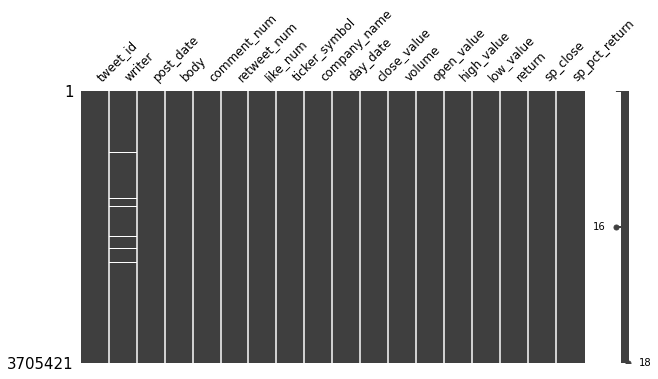

In [52]:
#note I swear this works but it just broke on my system's memory
#produces a nice heat style of missing data - I would say we don't really have missing data in the final df
missingno.matrix(final_df,figsize=(10,5), fontsize=12)

In [32]:
#cool that we are actually not missing a lot of data, basically have full data for all values.


In [53]:
final_df.describe()

,tweet_id,comment_num,retweet_num,like_num,close_value,volume,open_value,high_value,low_value,return,sp_close,sp_pct_return
count,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.703729e+06
mean,8.825025e+17,2.869946e-01,6.177506e-01,2.027946e+00,4.601062e+02,2.035185e+07,4.600215e+02,4.651276e+02,4.545439e+02,1.243132e-03,2.451504e+03,2.834690e-04
std,1.925688e+17,1.868682e+00,7.045150e+00,1.339141e+01,4.657105e+02,2.263473e+07,4.657048e+02,4.700767e+02,4.607222e+02,2.608636e-02,3.605926e+02,8.613595e-03
min,5.508798e+17,0.000000e+00,0.000000e+00,0.000000e+00,4.029000e+01,3.475180e+05,4.034000e+01,4.074000e+01,3.972000e+01,-1.390153e-01,1.829080e+03,-4.097924e-02
25%,7.195717e+17,0.000000e+00,0.000000e+00,0.000000e+00,1.287000e+02,3.769453e+06,1.285800e+02,1.296200e+02,1.278500e+02,-8.679704e-03,2.102150e+03,-2.986777e-03
50%,8.793614e+17,0.000000e+00,0.000000e+00,0.000000e+00,2.550100e+02,1.036460e+07,2.550500e+02,2.590000e+02,2.501800e+02,1.008488e-03,2.432540e+03,3.734622e-04
75%,1.054324e+18,0.000000e+00,0.000000e+00,1.000000e+00,7.042400e+02,3.059640e+07,7.036700e+02,7.116000e+02,6.968000e+02,1.152093e-02,2.784700e+03,4.620139e-03
max,1.212160e+18,6.310000e+02,9.990000e+02,9.990000e+02,2.039510e+03,1.691150e+08,2.038110e+03,2.050500e+03,2.013000e+03,1.766923e-01,3.240020e+03,4.959381e-02


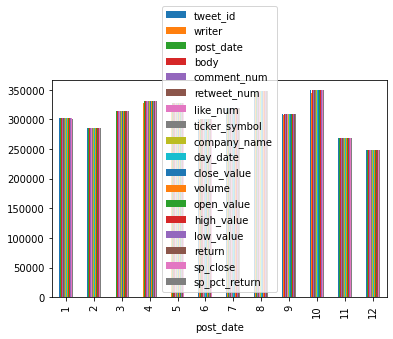

In [54]:
final_df.groupby(final_df["post_date"].dt.month).count().plot(kind="bar")